In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
'''
import gensim

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
'''
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import gensim

/home/15ucs099/anaconda3/lib/python3.5/site-packages/matplotlib-2.2.2+772.g640ecd9-py3.5-linux-x86_64.egg/matplotlib/__init__.py:961: UserWarning: could not find rc file; returning defaults
  warnings.warn(message)


In [2]:
df = pd.read_csv('Tweets.csv')
df = df.reindex(np.random.permutation(df.index)) 
df.reset_index(inplace=True)
df.drop('index',inplace=True,axis=1)
df = df[['text', 'airline_sentiment']]
df.head()

,text,airline_sentiment
0,@VirginAmerica for all my flight stuff wrong and did nothing about it. Had #worst #flight ever,negative
1,"@southwestair yeah, 7am flight tomorrow, going to add 60-90 min extra because of the roads / snow",neutral
2,@united no worries Your customer service gets a bad wrap but just spoke w agent who saved me huge amounts of time &amp; apologized for yesterday,positive
3,@United @Skywest do it again! I will now miss one or probably both our Aspen events. #Fail,negative
4,"@USAirways 4469, thank you for asking.",neutral


In [3]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        #finding all the substring containing the pattern in the tweet
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        #all the alphanumeric character
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?+', x))
        count_urls = X.apply(lambda x: self.count_regex(r'https?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

tc = TextCounts()

df_eda = tc.fit_transform(df.text)
df_eda.head()


,count_capital_words,count_emojis,count_excl_quest_marks,count_hashtags,count_mentions,count_urls,count_words
0,0,0,0,2,1,0,16
1,0,0,0,0,1,0,17
2,0,0,0,0,1,0,26
3,0,0,1,1,2,0,17
4,0,0,0,0,1,0,6


In [6]:
df_eda['airline_sentiment'] = df.airline_sentiment
df_eda.head()

,count_capital_words,count_emojis,count_excl_quest_marks,count_hashtags,count_mentions,count_urls,count_words,airline_sentiment
0,0,0,0,2,1,0,16,negative
1,0,0,0,0,1,0,17,neutral
2,0,0,0,0,1,0,26,positive
3,0,0,1,1,2,0,17,negative
4,0,0,0,0,1,0,6,neutral


In [7]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('airline_sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='airline_sentiment', size=5, hue='airline_sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_words
---------------------------------
                    count       mean       std  min   25%   50%   75%   max
airline_sentiment                                                          
negative           9178.0  20.387557  6.100020  2.0  17.0  22.0  25.0  35.0
neutral            3099.0  15.290094  7.150738  2.0  10.0  15.0  21.0  34.0
positive           2363.0  14.478206  7.266129  2.0  8.0   14.0  21.0  33.0


/home/15ucs099/anaconda3/lib/python3.5/site-packages/matplotlib-2.2.2+772.g640ecd9-py3.5-linux-x86_64.egg/matplotlib/axes/_axes.py:6178: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


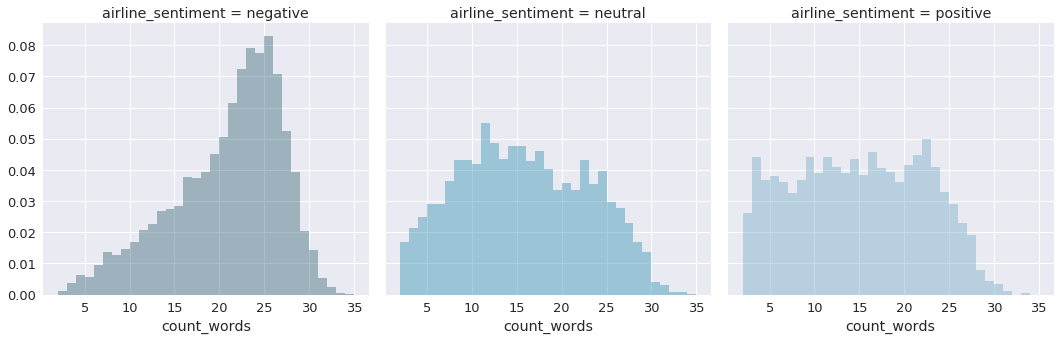

In [8]:

show_dist(df_eda, 'count_words')

Descriptive stats for count_mentions
------------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           9178.0  1.111244  0.365420  1.0  1.0  1.0  1.0  6.0
neutral            3099.0  1.167473  0.480102  1.0  1.0  1.0  1.0  5.0
positive           2363.0  1.138383  0.432462  1.0  1.0  1.0  1.0  6.0


/home/15ucs099/anaconda3/lib/python3.5/site-packages/matplotlib-2.2.2+772.g640ecd9-py3.5-linux-x86_64.egg/matplotlib/axes/_axes.py:6178: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


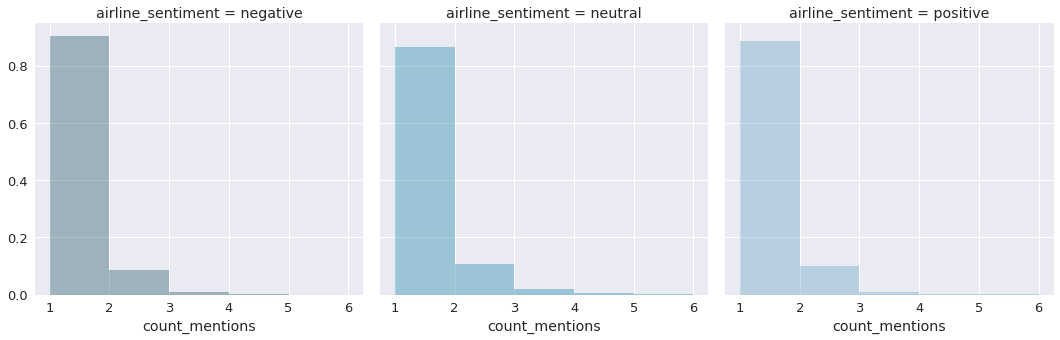

In [9]:
show_dist(df_eda, 'count_mentions')

Descriptive stats for count_hashtags
------------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           9178.0  0.233384  0.615099  0.0  0.0  0.0  0.0  6.0
neutral            3099.0  0.212004  0.666382  0.0  0.0  0.0  0.0  6.0
positive           2363.0  0.297503  0.774776  0.0  0.0  0.0  0.0  8.0


/home/15ucs099/anaconda3/lib/python3.5/site-packages/matplotlib-2.2.2+772.g640ecd9-py3.5-linux-x86_64.egg/matplotlib/axes/_axes.py:6178: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


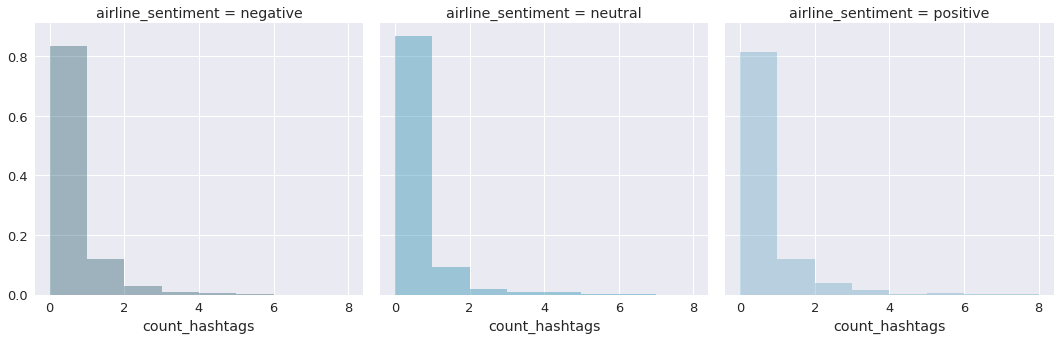

In [10]:
show_dist(df_eda, 'count_hashtags')


Descriptive stats for count_capital_words
-----------------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           9178.0  0.429070  1.019710  0.0  0.0  0.0  1.0  22.0
neutral            3099.0  0.462085  0.939468  0.0  0.0  0.0  1.0  11.0
positive           2363.0  0.461278  1.234078  0.0  0.0  0.0  1.0  20.0


/home/15ucs099/anaconda3/lib/python3.5/site-packages/matplotlib-2.2.2+772.g640ecd9-py3.5-linux-x86_64.egg/matplotlib/axes/_axes.py:6178: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


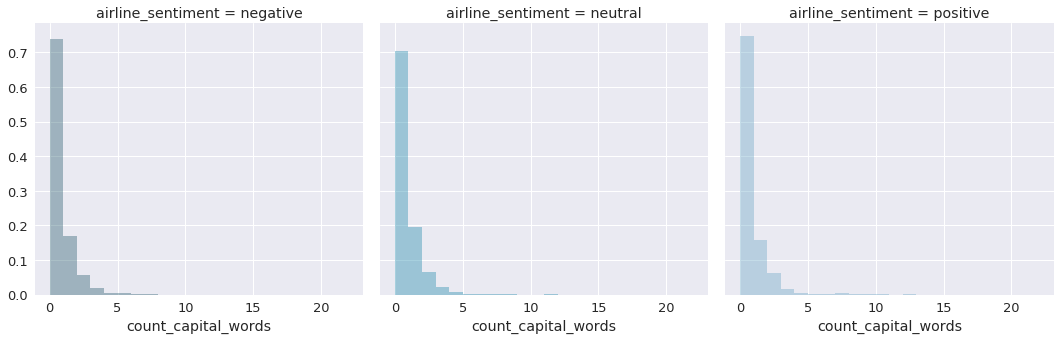

In [11]:
show_dist(df_eda, 'count_capital_words')


Descriptive stats for count_excl_quest_marks
--------------------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           9178.0  0.589235  1.041339  0.0  0.0  0.0  1.0  27.0
neutral            3099.0  0.639238  0.868104  0.0  0.0  0.0  1.0  12.0
positive           2363.0  0.890394  1.198117  0.0  0.0  1.0  1.0  13.0


/home/15ucs099/anaconda3/lib/python3.5/site-packages/matplotlib-2.2.2+772.g640ecd9-py3.5-linux-x86_64.egg/matplotlib/axes/_axes.py:6178: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


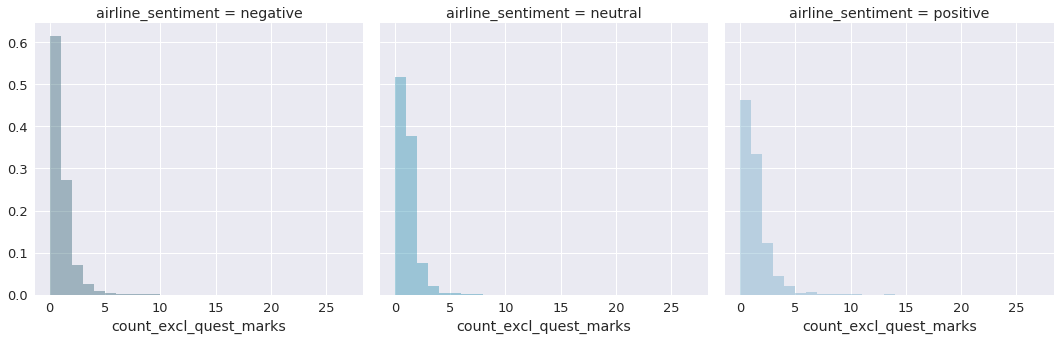

In [12]:
show_dist(df_eda, 'count_excl_quest_marks')


Descriptive stats for count_urls
--------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           9178.0  0.049248  0.218403  0.0  0.0  0.0  0.0  2.0
neutral            3099.0  0.169732  0.401225  0.0  0.0  0.0  0.0  3.0
positive           2363.0  0.098603  0.303818  0.0  0.0  0.0  0.0  2.0


/home/15ucs099/anaconda3/lib/python3.5/site-packages/matplotlib-2.2.2+772.g640ecd9-py3.5-linux-x86_64.egg/matplotlib/axes/_axes.py:6178: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


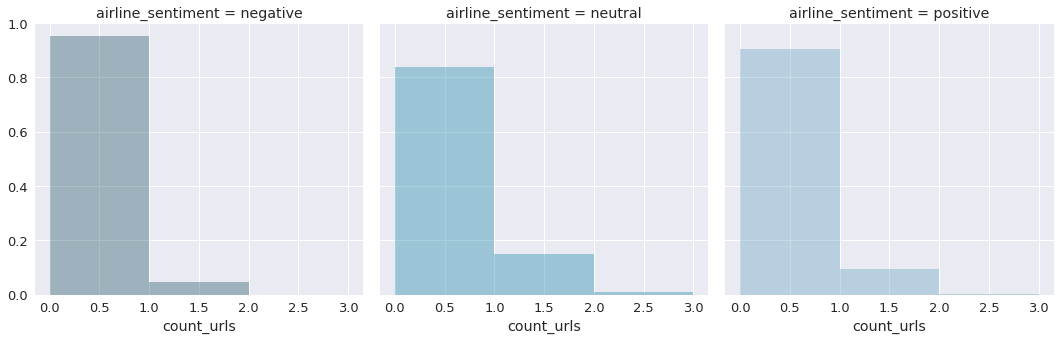

In [13]:
show_dist(df_eda, 'count_urls')


Descriptive stats for count_emojis
----------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           9178.0  0.028547  0.258772  0.0  0.0  0.0  0.0  8.0 
neutral            3099.0  0.075186  0.492514  0.0  0.0  0.0  0.0  13.0
positive           2363.0  0.179856  1.256408  0.0  0.0  0.0  0.0  40.0


/home/15ucs099/anaconda3/lib/python3.5/site-packages/matplotlib-2.2.2+772.g640ecd9-py3.5-linux-x86_64.egg/matplotlib/axes/_axes.py:6178: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


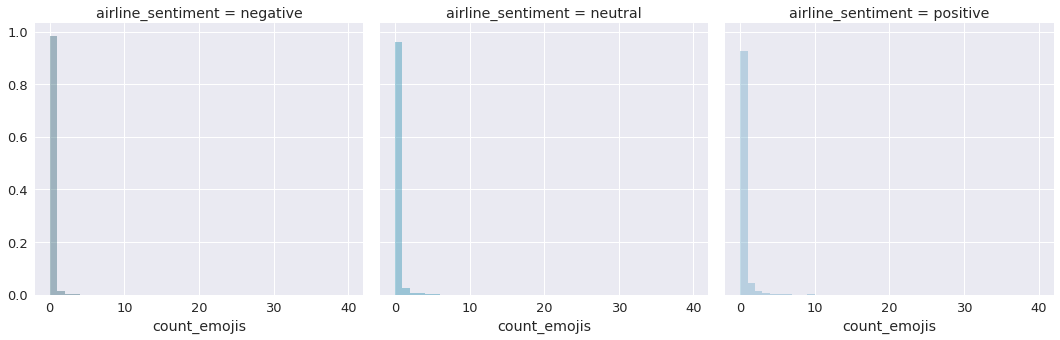

In [14]:
show_dist(df_eda, 'count_emojis')

In [15]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [16]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
ct = CleanText()
sr_clean = ct.fit_transform(df.text)
sr_clean.sample(5)
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

22 records have no words left after text cleaning


In [17]:
i=1
empty_clean = sr_clean == ''


print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'
print (sr_clean[0:5])

0 records have no words left after text cleaning
0    flight stuff wrong noth worst flight ever                                                 
1    yeah flight tomorrow go add min extra road snow                                           
2    no worri custom servic get bad wrap spoke agent save huge amount time amp apolog yesterday
3    miss one probabl aspen event fail                                                         
4    thank ask                                                                                 
Name: text, dtype: object


In [20]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
#printing only first 20
cv.get_feature_names()[0:20]
#bow.sum(axis=0)

['aa',
 'aaaand',
 'aaadvantag',
 'aaalwaysl',
 'aadavantag',
 'aadelay',
 'aadv',
 'aadvantag',
 'aafail',
 'aal',
 'aaron',
 'aaso',
 'aateam',
 'ab',
 'aback',
 'abandon',
 'abassinet',
 'abbrev',
 'abc',
 'abcletjetbluestreamfe']

      word  freq
0   flight  4879
1   thank   1703
2   get     1623
3   not     1586
4   no      1507
5   hour    1167
6   cancel  1065
7   help    1062
8   delay   1010
9   servic  1002
10  time    987 
11  custom  947 
12  call    792 
13  bag     771 
14  wait    754 
15  plane   735 
16  us      705 
17  fli     702 
18  need    688 
19  hold    687 


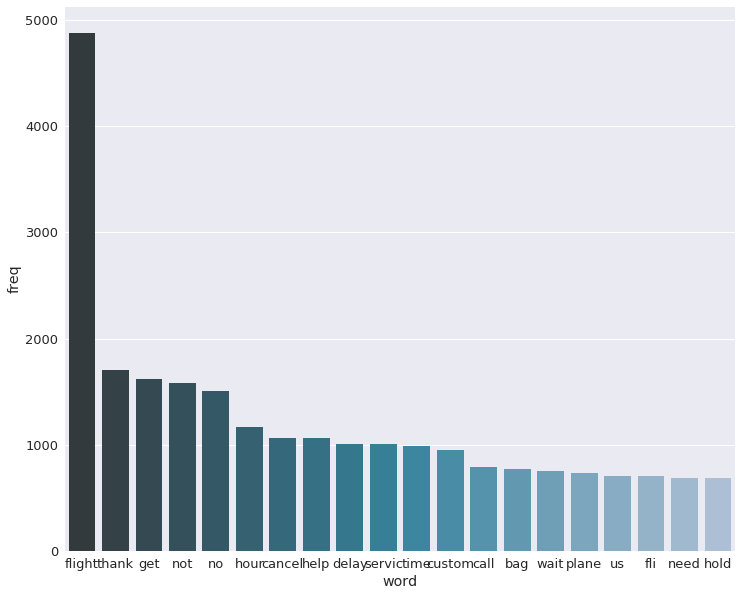

In [21]:
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
print(word_counter_df)

fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();


In [22]:
df_model = df_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['count_capital_words',
 'count_emojis',
 'count_excl_quest_marks',
 'count_hashtags',
 'count_mentions',
 'count_urls',
 'count_words',
 'airline_sentiment',
 'clean_text']

In [23]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        #print("I am in")
        
        #print(X[self.cols].dtype())
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment, test_size=0.1, random_state=37)

In [44]:
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        print("not good")
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        print("ok")
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=1)

    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_train, y_train))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
    print("Classification Report Train Data")
    print(classification_report(y_train, grid_search.best_estimator_.predict(X_train)))                    
    return grid_search

In [30]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}


# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}


# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (1.05, 1.1, 1.15,1.2),
    'clf__penalty': ('l1', 'l2')
}

In [31]:
mnb = MultinomialNB()
logreg = LogisticRegression()

In [32]:
countvect = CountVectorizer()

In [33]:
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

ok
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    5.8s finished


done in 6.774s

Best CV score: 0.779
Best parameters set:
	clf__alpha: 0.5
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.787


Test score with best_estimator_: 0.881


Classification Report Test Data
             precision    recall  f1-score   support

   negative       0.85      0.90      0.87       941
    neutral       0.58      0.50      0.54       287
   positive       0.75      0.69      0.72       236

avg / total       0.78      0.79      0.78      1464

Classification Report Train Data
             precision    recall  f1-score   support

   negative       0.91      0.93      0.92      8237
    neutral       0.80      0.74      0.77      2812
   positive       0.85      0.87      0.86      2127

avg / total       0.88      0.88      0.88     13176



In [34]:
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

ok
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (1.05, 1.1, 1.15, 1.2),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  2.4min finished


done in 145.882s

Best CV score: 0.795
Best parameters set:
	clf__C: 1.05
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.811


Test score with best_estimator_: 0.982


Classification Report Test Data
             precision    recall  f1-score   support

   negative       0.87      0.91      0.89       941
    neutral       0.64      0.59      0.61       287
   positive       0.77      0.67      0.72       236

avg / total       0.81      0.81      0.81      1464

Classification Report Train Data
             precision    recall  f1-score   support

   negative       0.99      0.99      0.99      8237
    neutral       0.96      0.96      0.96      2812
   positive       0.97      0.97      0.97      2127

avg / total       0.98      0.98      0.98     13176



TF-IDF (term frequency - inverse document frequency)  used to downweight these frequent words.

tfidf(t,d)=tf(t,d)∗idf(t,d)
 
where tf(t,d) is the number of times term t occurs in document d. The inverse document frequency can be computed as follows:

idf(t,d)=lognd1+df(d,t)
 
nd  is the number of documents
df(d,t) is the number of documents that contain term t

In [35]:
tfidfvect = TfidfVectorizer()

In [36]:
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

ok
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    6.2s finished


done in 7.136s

Best CV score: 0.748
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.770


Test score with best_estimator_: 0.848


Classification Report Test Data
             precision    recall  f1-score   support

   negative       0.78      0.96      0.86       941
    neutral       0.69      0.38      0.49       287
   positive       0.78      0.47      0.58       236

avg / total       0.76      0.77      0.74      1464

Classification Report Train Data
             precision    recall  f1-score   support

   negative       0.84      0.97      0.90      8237
    neutral       0.87      0.60      0.71      2812
   positive       0.89      0.68      0.77      2127

avg / total       0.85      0.85      0.84     13176



In [37]:
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

ok
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (1.05, 1.1, 1.15, 1.2),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  3.2min finished


done in 191.046s

Best CV score: 0.790
Best parameters set:
	clf__C: 1.15
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.804


Test score with best_estimator_: 0.843


Classification Report Test Data
             precision    recall  f1-score   support

   negative       0.84      0.93      0.89       941
    neutral       0.65      0.54      0.59       287
   positive       0.79      0.61      0.69       236

avg / total       0.80      0.80      0.80      1464

Classification Report Train Data
             precision    recall  f1-score   support

   negative       0.85      0.96      0.90      8237
    neutral       0.80      0.61      0.69      2812
   positive       0.87      0.69      0.77      2127

avg / total       0.84      0.84      0.84     13176



In [38]:
SIZE = 50

X_train['clean_text_wordlist'] = X_train.clean_text.apply(lambda x : word_tokenize(x))
X_test['clean_text_wordlist'] = X_test.clean_text.apply(lambda x : word_tokenize(x))
X_train['clean_text_wordlist'].head()
model = gensim.models.Word2Vec(X_train.clean_text_wordlist
                 , min_count=1
                 , size=SIZE
                 , window=5
                 , workers=4)

X_train.head()


,count_capital_words,count_emojis,count_excl_quest_marks,count_hashtags,count_mentions,count_urls,count_words,clean_text,clean_text_wordlist
9709,0,0,1,1,1,0,8,fli nashvil,"[fli, nashvil]"
12212,0,0,1,1,3,0,24,still think pj may sold love board us come,"[still, think, pj, may, sold, love, board, us, come]"
11438,0,0,0,0,1,0,25,appreci chang time min multipl time hour flight annoy seem like clue,"[appreci, chang, time, min, multipl, time, hour, flight, annoy, seem, like, clue]"
13844,0,0,0,0,1,0,24,unfortun patienc get boat leav pm hold watch flight fill,"[unfortun, patienc, get, boat, leav, pm, hold, watch, flight, fill]"
8781,1,0,0,0,1,1,30,flt lax fll ppl sleep id rather not disturb flight tri dl movi no go,"[flt, lax, fll, ppl, sleep, id, rather, not, disturb, flight, tri, dl, movi, no, go]"


In [39]:
model.most_similar('flight', topn=3)

/home/15ucs099/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[('rebook', 0.9876677989959717),
 ('flightlat', 0.9841099977493286),
 ('tomorrow', 0.9824616312980652)]

In [40]:
def compute_avg_w2v_vector(w2v_dict, tweet):
    list_of_word_vectors = [w2v_dict[w] for w in tweet if w in w2v_dict.vocab.keys()]
    
    if len(list_of_word_vectors) == 0:
        result = [0.0]*SIZE
    else:
        result = np.sum(list_of_word_vectors, axis=0) / len(list_of_word_vectors)
        
    return result

In [41]:
X_train_w2v = X_train['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))

X_test_w2v = X_test['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))
print(X_train.index)


Int64Index([ 9709, 12212, 11438, 13844,  8781, 12474, 13046,  8006, 12949,
            13903,
            ...
             6595,  5795, 11898,  4118, 12725,   988, 14587,  9036,  4459,
             1935],
           dtype='int64', length=13176)


In [42]:
X_train_w2v = pd.DataFrame(X_train_w2v.values.tolist(), index= X_train.index)
X_test_w2v = pd.DataFrame(X_test_w2v.values.tolist(), index= X_test.index)

# Concatenate with the TextCounts variables
X_train_w2v = pd.concat([X_train_w2v, X_train.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)
X_test_w2v = pd.concat([X_test_w2v, X_test.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)
X_train_w2v.head()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,count_capital_words,count_emojis,count_excl_quest_marks,count_hashtags,count_mentions,count_urls,count_words
9709,-0.233305,0.569635,-0.482216,0.324911,0.070882,0.329037,-0.027973,0.205157,0.599025,-0.177616,...,-0.125286,-0.170067,0.699998,0,0,1,1,1,0,8
12212,-0.222045,0.632078,-0.537508,0.366488,0.075658,0.287304,-0.001040,0.221889,0.575719,-0.242624,...,-0.110047,-0.216184,0.651532,0,0,1,1,3,0,24
11438,-0.180390,0.778435,-0.553215,0.410322,0.075281,0.247228,-0.023816,0.176980,0.609886,-0.347563,...,-0.075041,-0.214839,0.613404,0,0,0,0,1,0,25
13844,-0.151716,0.663203,-0.451885,0.341062,0.064204,0.197396,-0.022992,0.155782,0.516508,-0.298062,...,-0.063865,-0.186452,0.476014,0,0,0,0,1,0,24
8781,-0.174139,0.582780,-0.442664,0.308549,0.073706,0.225255,-0.025567,0.162181,0.512543,-0.240148,...,-0.087707,-0.181182,0.521329,1,0,0,0,1,1,30


In [45]:
best_logreg_w2v = grid_vect(logreg, parameters_logreg, X_train_w2v, X_test_w2v, is_w2v=True)

not good
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (1.05, 1.1, 1.15, 1.2), 'clf__penalty': ('l1', 'l2')}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/15ucs099/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/15ucs099/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/15ucs099/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/15ucs099/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/15ucs099/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1

done in 62.532s

Best CV score: 0.725
Best parameters set:
	clf__C: 1.2
	clf__penalty: 'l1'
Test score with best_estimator_: 0.726


Test score with best_estimator_: 0.729


Classification Report Test Data
             precision    recall  f1-score   support

   negative       0.76      0.93      0.84       941
    neutral       0.52      0.36      0.42       287
   positive       0.72      0.37      0.49       236

avg / total       0.71      0.73      0.70      1464

Classification Report Train Data
             precision    recall  f1-score   support

   negative       0.75      0.94      0.83      8237
    neutral       0.61      0.37      0.46      2812
   positive       0.73      0.39      0.51      2127

avg / total       0.72      0.73      0.70     13176



In [38]:
textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                         , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))
                                              , ('vect', CountVectorizer(max_df=0.5, min_df=1, ngram_range=(1,2)))]))]
                       , n_jobs=-1)

pipeline = Pipeline([
    ('features', features)
    , ('clf', LogisticRegression(C=1.0, penalty='l2'))
])

best_model = pipeline.fit(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment)

In [39]:
new_positive_tweets = pd.Series(["Thank you @VirginAmerica for you amazing customer support team on Tuesday 11/28 at @EWRairport and returning my lost bag in less than 24h! #efficiencyiskey #virginamerica"
                      ,"Love flying with you guys ask these years.  Sad that this will be the last trip 😂   @VirginAmerica  #LuxuryTravel"
                      ,"Wow @VirginAmerica main cabin select is the way to fly!! This plane is nice and clean & I have tons of legroom! Wahoo! NYC bound! ✈️"])

df_counts_pos = tc.transform(new_positive_tweets)
df_clean_pos = ct.transform(new_positive_tweets)
df_model_pos = df_counts_pos
df_model_pos['clean_text'] = df_clean_pos

best_model.predict(df_model_pos).tolist()

['positive', 'positive', 'positive']

In [40]:
new_negative_tweets = pd.Series(["@VirginAmerica shocked my initially with the service, but then went on to shock me further with no response to what my complaint was. #unacceptable @Delta @richardbranson"
                      ,"@VirginAmerica this morning I was forced to repack a suitcase w a medical device because it was barely overweight - wasn't even given an option to pay extra. My spouses suitcase then burst at the seam with the added device and had to be taped shut. Awful experience so far!"
                      ,"Board airplane home. Computer issue. Get off plane, traverse airport to gate on opp side. Get on new plane hour later. Plane too heavy. 8 volunteers get off plane. Ohhh the adventure of travel ✈️ @VirginAmerica"])

df_counts_neg = tc.transform(new_negative_tweets)
df_clean_neg = ct.transform(new_negative_tweets)
df_model_neg = df_counts_neg
df_model_neg['clean_text'] = df_clean_neg

best_model.predict(df_model_neg).tolist()

['negative', 'negative', 'negative']

In [43]:
X_test


,count_capital_words,count_emojis,count_excl_quest_marks,count_hashtags,count_mentions,count_urls,count_words,clean_text,clean_text_wordlist
10620,0,0,0,0,1,0,6,chantilli pari franc,"[chantilli, pari, franc]"
13609,0,0,0,0,1,0,11,custom servic experi tweet qualiti assur,"[custom, servic, experi, tweet, qualiti, assur]"
2955,0,0,0,0,1,0,26,pl stop send text everi min say flight delay anoth min hr usual defend lame,"[pl, stop, send, text, everi, min, say, flight, delay, anoth, min, hr, usual, defend, lame]"
3585,0,0,1,0,1,0,9,absolut send,"[absolut, send]"
2087,0,0,0,0,1,0,3,come scoop,"[come, scoop]"
12382,0,0,1,0,4,0,22,help wrong stuck florida day need learn real airlin,"[help, wrong, stuck, florida, day, need, learn, real, airlin]"
4062,0,0,0,0,1,0,17,thank find lower fare alreadi carrier direct flight juli,"[thank, find, lower, fare, alreadi, carrier, direct, flight, juli]"
3567,0,0,1,0,1,0,26,check right hr mark board group kid age amp dnt want split sld,"[check, right, hr, mark, board, group, kid, age, amp, dnt, want, split, sld]"
10064,0,0,1,0,1,0,11,thank good back safe see soon,"[thank, good, back, safe, see, soon]"
1809,0,0,0,1,1,0,7,link flyfi,"[link, flyfi]"
